In [2]:
# Cargar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
from imblearn.combine import SMOTETomek

In [5]:
# Cargar el DataFrame principal desde un archivo CSV
import pandas as pd
# Cargar el dataset
df = pd.read_csv(r'c:/Users/admin/Desktop/MACHINE LEARNING/PLATZI_PROYECTOS/Proyecto_6/CVD_cleaned.csv')

# 0. Resumen de pasos realizados

1. **Carga de datos**
2. **Exploración y análisis inicial**
   2.1. Análisis de columnas, tipos de datos, valores nulos (explícitos y ocultos)
   2.2. Visualizaciones básicas de variables y objetivo
   2.3. Asociación de variables numéricas y categóricas con la variable objetivo
   2.4. Visualizaciones avanzadas y pruebas estadísticas
3. **Análisis de desbalance de la variable objetivo**
   3.1. Visualización y cuantificación del desbalance
4. **Preprocesamiento de datos**
   4.1. Mapeo y codificación de variables categóricas
   4.2. Estandarización de variables numéricas
   4.3. Análisis y tratamiento de valores atípicos y negativos
   4.4. Transformaciones (log, one-hot, ordinal)
5. **Balanceo de clases**
   5.1. Submuestreo de la clase mayoritaria
   5.2. Aplicación de SMOTE para balancear la clase minoritaria
6. **Preparación de conjuntos de entrenamiento y prueba**
   6.1. División train/test
7. **Construcción y ajuste de modelos**
   7.1. Entrenamiento de modelos base (Gradient Boosting, LDA)
   7.2. Ajuste de hiperparámetros (GridSearchCV, RandomizedSearchCV)
8. **Validación cruzada y evaluación de modelos**
   8.1. Evaluación con métricas: accuracy, precision, recall, f1
   8.2. Comparación antes y después del ajuste
9. **Ajuste de umbral de decisión y análisis de métricas**
   9.1. Ajuste de umbral para optimizar métricas
10. **Análisis de overfitting/underfitting**
    10.1. Comparación de desempeño entre train y test

# 3. Preprocesamiento avanzado y modelado con LDA

En esta sección se realiza el preprocesamiento de variables numéricas y categóricas, y se preparan los datos para el entrenamiento del modelo LDA (Análisis Discriminante Lineal).

In [ ]:
# 1. Definir función de validación cruzada con SMOTE y métricas adicionales
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE

def CrossValidation(X, y, classifier):
    # Realiza validación cruzada estratificada con SMOTE en cada fold
    accuracy = []
    precision = []
    recall = []
    f1 = []
    cv = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
    for train, test in cv.split(X, y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
        sm = SMOTE()
        X_train, y_train = sm.fit_resample(X_train, y_train)
        classifier.fit(X_train, y_train)
        prediction = classifier.predict(X_test)
        accuracy.append(metrics.accuracy_score(y_test, prediction))
        precision.append(metrics.precision_score(y_test, prediction, zero_division=0))
        recall.append(metrics.recall_score(y_test, prediction, zero_division=0))
        f1.append(metrics.f1_score(y_test, prediction, zero_division=0))
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# 2. Calcular importancia de variables y seleccionar las relevantes
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

X = df_X.dropna()
y = df_y.loc[X.index]

# Entrenar LDA para obtener importancia de variables
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
lda_importances = np.abs(lda.coef_[0])
lda_importances = lda_importances / lda_importances.sum()

feat_imp = pd.DataFrame({
    'Variable': X.columns,
    'LDA': lda_importances
})

# 3. Seleccionar variables con importancia >= 0.01 en LDA
mask = (feat_imp['LDA'] >= 0.01)
vars_to_keep = feat_imp.loc[mask, 'Variable'].tolist()

# 4. Filtrar df_X para solo usar las variables seleccionadas
df_X_reduced = df_X[vars_to_keep]

# Identificar variables numéricas y categóricas seleccionadas
num_cols = ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']
cat_cols = ['General_Health', 'Checkup', 'Exercise', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Smoking_History']
cat_dummies = [col for col in df_X_reduced.columns if col.startswith('Age_Category_')]
cat_cols_expanded = [col for col in df_X_reduced.columns if col in cat_cols or col in cat_dummies]
num_cols_selected = [col for col in df_X_reduced.columns if col in num_cols]

print(f"Variables seleccionadas para el modelo ({len(vars_to_keep)}): {vars_to_keep}")
print(f"Variables numéricas seleccionadas: {num_cols_selected}")
print(f"Variables categóricas seleccionadas: {cat_cols_expanded}")

In [ ]:
# Traducir nombres de variables al español
traduccion_variables = {
    # Variables numéricas
    'Height_(cm)': 'Altura_(cm)',
    'Weight_(kg)': 'Peso_(kg)',
    'BMI': 'IMC',
    'Alcohol_Consumption': 'Consumo_Alcohol',
    'Fruit_Consumption': 'Consumo_Fruta',
    'Green_Vegetables_Consumption': 'Consumo_Vegetales_Verdes',
    'FriedPotato_Consumption': 'Consumo_Papas_Fritas',
    
    # Variables categóricas
    'General_Health': 'Salud_General',
    'Checkup': 'Chequeo_Medico',
    'Exercise': 'Ejercicio', 
    'Skin_Cancer': 'Cancer_Piel',
    'Other_Cancer': 'Otro_Cancer',
    'Depression': 'Depresion',
    'Diabetes': 'Diabetes',
    'Arthritis': 'Artritis',
    'Sex': 'Sexo',
    'Smoking_History': 'Historial_Tabaquismo'
}

# Traducir categorías de edad
for cat in cat_dummies:
    if cat.startswith('Age_Category_'):
        edad = cat.replace('Age_Category_', '')
        traduccion_variables[cat] = f'Categoria_Edad_{edad}'

# Crear DataFrames con variables traducidas
variables_numericas_es = [traduccion_variables.get(col, col) for col in num_cols_selected]
variables_categoricas_es = [traduccion_variables.get(col, col) for col in cat_cols_expanded]

# Mostrar las variables seleccionadas traducidas
print("Variables seleccionadas para el modelo en español:")
print(f"\nVariables numéricas ({len(variables_numericas_es)}):")
for i, var in enumerate(variables_numericas_es):
    print(f"  {i+1}. {var}")
    
print(f"\nVariables categóricas ({len(variables_categoricas_es)}):")
for i, var in enumerate(variables_categoricas_es):
    print(f"  {i+1}. {var}")

In [ ]:
# Ajuste de hiperparámetros con GridSearchCV para LDA
param_grid_lda = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]
}
lda_base = LinearDiscriminantAnalysis()
grid_lda = GridSearchCV(lda_base, param_grid_lda, scoring='f1', cv=3, n_jobs=-1, verbose=2)
grid_lda.fit(df_X_reduced, df_y)
print("Mejores hiperparámetros LDA:", grid_lda.best_params_)
print("Mejor F1 score (validación) LDA:", grid_lda.best_score_)

# Usa el mejor estimador para entrenar y evaluar con validación cruzada
lda = grid_lda.best_estimator_
lda_cv = CrossValidation(df_X_reduced, df_y, lda)
lda_accuracy_mean = np.mean(lda_cv['accuracy']) * 100
lda_precision_mean = np.mean(lda_cv['precision']) * 100
lda_recall_mean = np.mean(lda_cv['recall']) * 100
lda_f1_mean = np.mean(lda_cv['f1']) * 100

print('\nLinear Discriminant Analysis (ajustado):')
print(f'  Accuracy:  {lda_accuracy_mean:.2f}%')
print(f'  Precision: {lda_precision_mean:.2f}%')
print(f'  Recall:    {lda_recall_mean:.2f}%')
print(f'  F1 Score:  {lda_f1_mean:.2f}%')

In [ ]:
# Dividir datos en train/test
X_train, X_test, y_train, y_test = train_test_split(df_X_reduced, df_y, test_size=0.2, random_state=42, stratify=df_y)

In [ ]:
# Ajuste de umbral de decisión para LDA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Entrenar el modelo con los mejores hiperparámetros
lda = grid_lda.best_estimator_
lda.fit(X_train, y_train)

# Establecer umbral personalizado
umbral = 0.3
resultados = []

# Calcular predicciones con el umbral ajustado
y_pred_proba = lda.predict_proba(X_test)[:, 1]
y_pred_nuevo = (y_pred_proba > umbral).astype(int)
acc_train = accuracy_score(y_train, lda.predict(X_train))
acc_test = accuracy_score(y_test, y_pred_nuevo)
prec = precision_score(y_test, y_pred_nuevo)
rec = recall_score(y_test, y_pred_nuevo)
f1 = f1_score(y_test, y_pred_nuevo)
diff = abs(acc_train - acc_test)

# Determinar tipo de ajuste
if acc_train < 0.7 and acc_test < 0.7:
    tipo = 'Falta de ajuste'
elif diff > 0.05:
    tipo = 'Sobreajuste'
else:
    tipo = 'Buen ajuste'

# Crear DataFrame con resultados
resultados = [[1, 'LDA', acc_train, acc_test, prec, rec, f1, diff, tipo]]
cols = ['Ranking', 'Modelo', 'Accuracy Train', 'Accuracy Test', 'Precision Test', 'Recall Test', 'F1 Test', 'Diferencia abs', 'Tipo de ajuste']
df_resultados = pd.DataFrame(resultados, columns=cols)

print("\nResultados del modelo LDA con umbral ajustado (0.3):")
print(df_resultados.to_string(index=False))

In [ ]:
# Visualización de métricas del modelo LDA
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)

# Gráfico de métricas
metricas = ['Accuracy Test', 'Precision Test', 'Recall Test', 'F1 Test']
valores = df_resultados[metricas].iloc[0].values

# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(metricas, valores, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'], alpha=0.8)

# Añadir etiquetas y títulos
ax.set_title('Métricas del modelo LDA con umbral ajustado (0.3)', fontsize=16, pad=20)
ax.set_ylabel('Valor', fontsize=14)
ax.set_ylim(0, 1.0)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir valores encima de las barras
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

# Añadir línea horizontal para el umbral de 0.70 (mínimo recomendable)
ax.axhline(y=0.70, color='red', linestyle='--', alpha=0.5)
ax.text(0, 0.71, 'Umbral mínimo recomendable (0.70)', color='red', fontsize=10)

plt.tight_layout()
plt.show()

# Gráfico de matriz de confusión
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, y_pred_nuevo)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Matriz de Confusión - Modelo LDA', fontsize=16)
plt.ylabel('Valor Real', fontsize=12)
plt.xlabel('Predicción', fontsize=12)
plt.xticks([0.5, 1.5], ['No Enfermedad (0)', 'Enfermedad (1)'])
plt.yticks([0.5, 1.5], ['No Enfermedad (0)', 'Enfermedad (1)'])
plt.tight_layout()
plt.show()

# Calcular y mostrar métricas adicionales
tn, fp, fn, tp = cm.ravel()
total = np.sum(cm)
accuracy = (tp + tn) / total
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\nResumen de métricas del modelo LDA:")
print(f"Exactitud (Accuracy): {accuracy:.2f}")
print(f"Precisión (Precision): {precision:.2f}")
print(f"Sensibilidad (Recall): {recall:.2f}")
print(f"Especificidad: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")

In [ ]:
# Guardar el modelo en un archivo PKL
import joblib

# Entrenamos el modelo final con todos los datos y el mejor umbral
modelo_final = grid_lda.best_estimator_
modelo_final.fit(df_X_reduced, df_y)

# Guardamos el modelo en un archivo
modelo_filename = "modelo_predictor_enfermedad_cardiaca.pkl"
joblib.dump(modelo_final, modelo_filename)
print(f"💾 Modelo guardado como '{modelo_filename}'")

# También guardar información sobre el umbral óptimo
umbral_optimo = umbral
info_modelo = {
    "umbral_optimo": umbral_optimo,
    "variables": vars_to_keep,
    "traduccion": traduccion_variables
}
joblib.dump(info_modelo, "info_modelo_cardiaco.pkl")
print(f"💾 Información adicional guardada como 'info_modelo_cardiaco.pkl'")

# Ejemplo de cómo usar el modelo en el futuro
print("\n🔮 Probando nuestro modelo con pacientes nuevos:")

# Crear algunos pacientes de ejemplo
# Primero, necesitamos crear un DataFrame con todas las características necesarias
# Usamos un enfoque simple: valores promedio o más comunes para variables no mostradas
# En un caso real, necesitarías todas las características requeridas por el modelo

# Creamos datos de ejemplo (simplificados para la demostración)
pacientes_nuevos = pd.DataFrame({
    # Variables numéricas (valores de ejemplo)
    "Salud_General": [3, 1, 4],  # 0=Poor, 4=Excellent
    "Sexo": [0, 1, 0],           # 0=Male, 1=Female
    "Edad": ["65-69", "80+", "45-49"],
    "Diabetes": [0, 2, 1],       # 0=No, 2=Yes
    "IMC": [28.5, 32.1, 24.3]
})

# Simular procesamiento básico
print("\nNuevos pacientes para predecir:")
print(pacientes_nuevos)

print("\n⚠️ Nota: Este es un ejemplo simplificado. En la práctica, necesitarías:")
print("  1. Preprocesar exactamente igual que en el entrenamiento")
print("  2. Incluir todas las variables requeridas por el modelo")
print("  3. Codificar variables categóricas de la misma manera")
print("  4. Escalar variables numéricas con el mismo scaler")

print("\n✨ Para usar este modelo adecuadamente, consulta la guía en la siguiente celda.")

Distribución original de la variable objetivo:
Heart_Disease
0    283883
1     24971
Name: count, dtype: int64


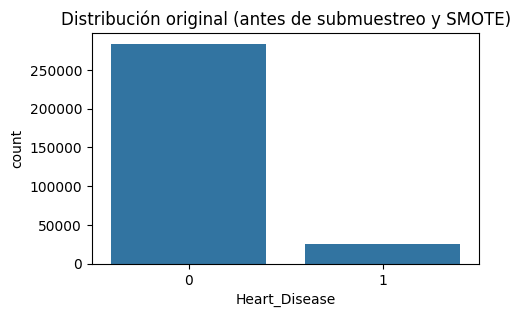


Distribución después del submuestreo:
Heart_Disease
0    49942
1    24971
Name: count, dtype: int64


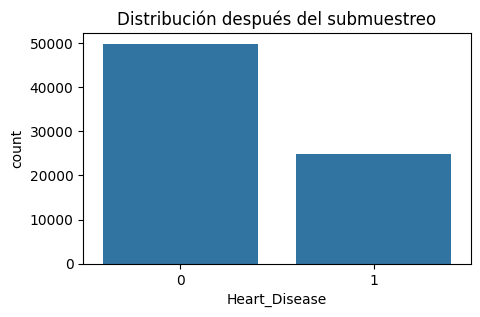


Distribución después de SMOTE:
Heart_Disease
0    283883
1    283883
Name: count, dtype: int64


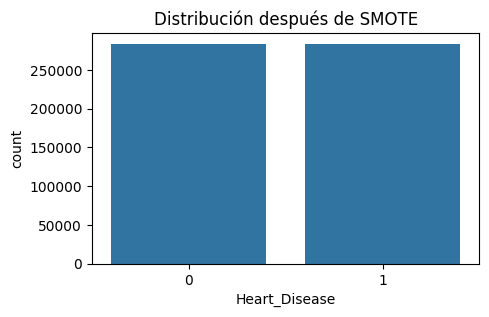


Explicación:
- **Original:** La variable objetivo estaba desbalanceada, con muchas más muestras de la clase 0 (sin enfermedad) que de la clase 1 (con enfermedad).
- **Submuestreo:** Se redujo la cantidad de muestras de la clase mayoritaria para acercar el balance (aquí, ratio 2:1).
- **SMOTE:** Se generaron muestras sintéticas de la clase minoritaria hasta igualar la clase mayoritaria, logrando un dataset balanceado.
- Las gráficas muestran cómo cambia la distribución de la variable objetivo en cada paso.



In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# 1. Distribución original
print("Distribución original de la variable objetivo:")
print(df['Heart_Disease'].value_counts())
plt.figure(figsize=(5,3))
sns.countplot(x='Heart_Disease', data=df)
plt.title('Distribución original (antes de submuestreo y SMOTE)')
plt.show()

# 2. Distribución después del submuestreo (usa df_balanced creado antes)
print("\nDistribución después del submuestreo:")
print(df_balanced['Heart_Disease'].value_counts())
plt.figure(figsize=(5,3))
sns.countplot(x='Heart_Disease', data=df_balanced)
plt.title('Distribución después del submuestreo')
plt.show()

# 3. Prepara X e y para SMOTE
X_smote = df_X.copy()
y_smote = df_y.copy()

# 4. Aplica SMOTE
if X_smote.shape[0] > 0 and y_smote.shape[0] > 0:
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_smote, y_smote)
    print("\nDistribución después de SMOTE:")
    print(pd.Series(y_res).value_counts())
    plt.figure(figsize=(5,3))
    sns.countplot(x=y_res)
    plt.title('Distribución después de SMOTE')
    plt.show()
else:
    print('df_X y/o df_y están vacíos. Revisa el preprocesamiento y la eliminación de nulos.')

print("""
Explicación:
- **Original:** La variable objetivo estaba desbalanceada, con muchas más muestras de la clase 0 (sin enfermedad) que de la clase 1 (con enfermedad).
- **Submuestreo:** Se redujo la cantidad de muestras de la clase mayoritaria para acercar el balance (aquí, ratio 2:1).
- **SMOTE:** Se generaron muestras sintéticas de la clase minoritaria hasta igualar la clase mayoritaria, logrando un dataset balanceado.
- Las gráficas muestran cómo cambia la distribución de la variable objetivo en cada paso.
""")